In [ ]:
%python

spark.conf.set(
    "fs.azure.account.key.<storage_account>.dfs.core.windows.net",
    "<access_key>"
)


from pyspark.sql import functions as F

path = "abfs://taxi@stefanloansstorage01.dfs.core.windows.net/taxi/"

files = dbutils.fs.ls(path)

dfs = []

for f in files:
    if f.name.endswith(".parquet"):
        tmp = spark.read.parquet(f.path)
        dfs.append(tmp)

df = dfs[0]

for d in dfs[1:]:
    df = df.unionByName(d, allowMissingColumns=True)

display(df)


In [ ]:
%python
df.count()

38310226

In [ ]:
%python
df.printSchema()


root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [ ]:
%python
#ciscenje podataka, tamo gde nema ovih podataka redovi su beskorisni, a tamo gde se ponalvjaju to je ocigleda duplikat
identity_cols = [
    "VendorID",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "trip_distance"
]

df = df.dropna(subset=identity_cols)
df = df.dropDuplicates(identity_cols)


In [ ]:
%python
# dodavanje nula tamo gde je nan za podatke koji su ili nula ili veci iznosi
df = df.fillna({
    "tip_amount": 0,
    "tolls_amount": 0,
    "extra": 0,
    "airport_fee": 0,
    "congestion_surcharge": 0
})


In [ ]:
%python
#tamo gde nema ovih podataka redovi su beskorisni, jer su bitni za analizu, a ne mozemo unositi proizvoljno brojeve (interpoalcije forwardfill, backwardfill, meadin, mode, mean nisu bas idealni)
df = df.dropna(subset=[
    "passenger_count",
    "fare_amount",
    "trip_distance"
])


In [ ]:
%python
from pyspark.sql.functions import unix_timestamp

#pravljenje jednog od feature za machine elarning (ostala su jos dva ali oni nemaju outlinere)
df = df.withColumn(
    "trip_duration_min",
    (unix_timestamp("tpep_dropoff_datetime") -
     unix_timestamp("tpep_pickup_datetime")) / 60
)


In [ ]:
%python

#filtriranje zapravo izbacuje outlinere koji bi bili greske

from pyspark.sql.functions import col

df = df.filter(
    (col("trip_distance") > 0) & (col("trip_distance") <= 100) &
    (col("trip_duration_min") > 1) & (col("trip_duration_min") <= 300) &
    (col("passenger_count") >= 1) & (col("passenger_count") <= 6) &
    (col("fare_amount") >= 2.5) & (col("fare_amount") <= 500) &
    (col("extra") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0)
)


In [ ]:
%python
#dodavanje dva featura dan i vreme kada je voznja( moze biti spic, ponoc itd)
from pyspark.sql.functions import hour, dayofweek

df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
df = df.withColumn("pickup_dayofweek", dayofweek("tpep_pickup_datetime"))


In [ ]:
%python
#ono sto predvidjam
label_col = "fare_amount"


In [ ]:
%python
#featuri
feature_cols = [
    "trip_distance",
    "trip_duration_min",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek",
    "PULocationID",
    "DOLocationID"
]


In [ ]:
%python
# TEST se zaključava
train_val_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# TRAIN i VALIDATION
train_df, val_df = train_val_df.randomSplit([0.8, 0.2], seed=42)



In [ ]:
%python

# uzimanje samo 5% podataka
train_df = train_df.sample(fraction=0.05, seed=42)
val_df   = val_df.sample(fraction=0.05, seed=42)
test_df  = test_df.sample(fraction=0.05, seed=42)


In [ ]:
%python

#mapiranje u indexe za podatke (ove tri kolone/ long vrsta podataka da machine learning ih ne bi prepoznao kao 100,200 itd) koji idu za train
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

index_cols = ["PULocationID", "DOLocationID", "VendorID"]

indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=f"{c}_idx",
        handleInvalid="keep"
    ) for c in index_cols
]

indexer_pipeline = Pipeline(stages=indexers)
indexer_model = indexer_pipeline.fit(train_df)


In [ ]:
%python
# transformacija  - primena naucenog prethodnog mapiranja 

train_df = indexer_model.transform(train_df)
val_df   = indexer_model.transform(val_df)
test_df  = indexer_model.transform(test_df)




In [ ]:
%python
#finalni featuri

final_feature_cols = [
    "trip_distance",
    "trip_duration_min",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek",
    "PULocationID_idx",
    "DOLocationID_idx",
    "VendorID_idx"
]


In [ ]:
%python
# definisanje VectorAssembler i Primenjuje definisani VectorAssembler na train, validation i test skupove podataka. Ubacuje feature u jednu kolonu.

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

train_df = assembler.transform(train_df)
val_df   = assembler.transform(val_df)
test_df  = assembler.transform(test_df)



In [ ]:
%python
# odredjivanje evaluatora modela
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="mae"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="r2"
)



In [ ]:
%python
# 1 model- linearna regresija


from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features",
    labelCol="fare_amount"
)

lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(val_df)

print("LR RMSE:", evaluator_rmse.evaluate(lr_pred))
print("LR MAE :", evaluator_mae.evaluate(lr_pred))
print("LR R2  :", evaluator_r2.evaluate(lr_pred))




LR RMSE: 4.5713069515416365
LR MAE : 1.6517223665973455
LR R2  : 0.93464844866324


In [ ]:
%python
# 2 model - random forest

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="fare_amount",
    numTrees=20,        # ⬅ smanjeno
    maxDepth=8,         # ⬅ smanjeno
    maxBins=300,        # ⬅ zbog ID kolona
    subsamplingRate=0.7,
    seed=42
)

rf_model = rf.fit(train_df)
rf_pred = rf_model.transform(val_df)

print("RF RMSE:", evaluator_rmse.evaluate(rf_pred))
print("RF MAE :", evaluator_mae.evaluate(rf_pred))
print("RF R2  :", evaluator_r2.evaluate(rf_pred))


RF RMSE: 3.5671832339315293
RF MAE : 1.047368803656452
RF R2  : 0.9602052326863831


In [ ]:
%python
# za gradient boosting smo izbacili ID kolone jer previse vremena bi trajalo



final_feature_cols_gbt = [
"trip_distance",
"trip_duration_min",
"passenger_count",
"pickup_hour",
"pickup_dayofweek"
]

In [ ]:
%python

# kolone featuri su prebaceni u jendu kolonu za gradient boosting

from pyspark.ml.feature import VectorAssembler

assembler_gbt = VectorAssembler(
inputCols=final_feature_cols_gbt,
outputCol="features_gbt"
)

train_gbt = assembler_gbt.transform(train_df)
val_gbt = assembler_gbt.transform(val_df)

In [ ]:
%python
# 3 model - gradient boosting

from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
featuresCol="features_gbt",
labelCol="fare_amount",
maxIter=5,
maxDepth=3,
seed=42
)

gbt_model = gbt.fit(train_gbt)
gbt_pred = gbt_model.transform(val_gbt)

print("GBT RMSE:", evaluator_rmse.evaluate(gbt_pred))
print("GBT MAE :", evaluator_mae.evaluate(gbt_pred))
print("GBT R2 :", evaluator_r2.evaluate(gbt_pred))

GBT RMSE: 6.089291152593628
GBT MAE : 2.521839729885302
GBT R2 : 0.8840398914806226


In [ ]:
%python
# 5% uzorak od preko 38milion tj oko 2 miliona
df_5 = df.sample(fraction=0.05, seed=42)

In [ ]:
%python
df_sample = df.sample(
    fraction=0.01,
    seed=42
)


In [ ]:
%python
# train i test
train_final, test_final = df_5.randomSplit([0.8, 0.2], seed=42)

In [ ]:
%python
# mapiranje ID-eve u indexe
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

index_cols = ["PULocationID", "DOLocationID", "VendorID"]

indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=f"{c}_idx",
        handleInvalid="keep"
    ) for c in index_cols
]

indexer_pipeline = Pipeline(stages=indexers)
indexer_model = indexer_pipeline.fit(train_final)

In [ ]:
%python

# pretvaranje ID-eve u indexe
train_final = indexer_model.transform(train_final)
test_final  = indexer_model.transform(test_final)


In [ ]:
%python
#featuresi
final_feature_cols = [
    "trip_distance",
    "trip_duration_min",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek",
    "PULocationID_idx",
    "DOLocationID_idx",
    "VendorID_idx"
]


In [ ]:
%python

# prebacivnaje featursa iz vise kolona u jednu
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

train_final = assembler.transform(train_final)
test_final  = assembler.transform(test_final)


In [ ]:
%python
#model-random forest
from pyspark.ml.regression import RandomForestRegressor

rf_final = RandomForestRegressor(
    featuresCol="features",
    labelCol="fare_amount",
    numTrees=20,
    maxDepth=8,
    maxBins=300,
    subsamplingRate=0.7,
    seed=42
)

rf_final_model = rf_final.fit(train_final)
rf_test_pred = rf_final_model.transform(test_final)

In [ ]:
%python


# model pokazuje da je greska u proceni cene taksija u proseku oko 1 dolar a za skuplje voznje oko 3.5 dolara. Takodje model objasnjava 96% varijacija cene taksija.
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE
evaluator_rmse = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="rmse"
)

# MAE
evaluator_mae = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="mae"
)

# R2
evaluator_r2 = RegressionEvaluator(
    labelCol="fare_amount",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(rf_test_pred)
mae  = evaluator_mae.evaluate(rf_test_pred)
r2   = evaluator_r2.evaluate(rf_test_pred)

print("TEST RMSE:", rmse)
print("TEST MAE :", mae)
print("TEST R2  :", r2)

TEST RMSE: 3.5221062664419436
TEST MAE : 1.0457313168169309
TEST R2  : 0.9611886859877399


In [ ]:
%python
# model pokazuje da je najbitniji feature duzina puta i koliko minuta traje, zatim lokacije ulaksa i izlaska iz taksija, a ostale su manje relevatne.

import pandas as pd

importances = rf_final_model.featureImportances.toArray()

fi_df = pd.DataFrame({
    "feature": final_feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df

,feature,importance
0,trip_distance,0.397141
1,trip_duration_min,0.324858
5,PULocationID_idx,0.167471
6,DOLocationID_idx,0.107717
3,pickup_hour,0.001737
2,passenger_count,0.000480
7,VendorID_idx,0.000410
4,pickup_dayofweek,0.000186


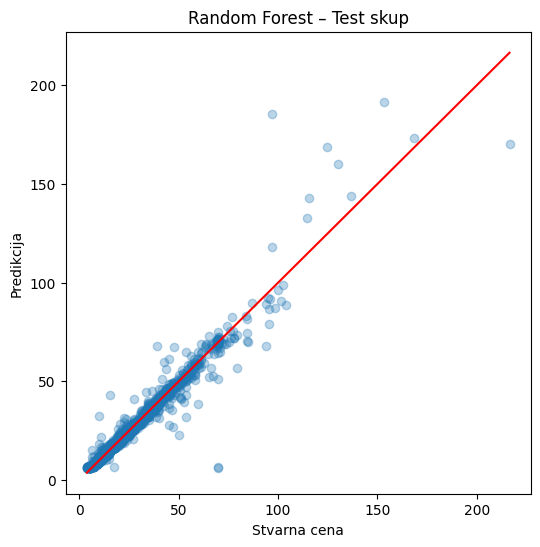

In [ ]:
%python

# scatterplot pokazuje da je model precizan pri nizim cenama a da posotje odstupanja pri visim cenama

sample_pd = (
    rf_test_pred
    .select("fare_amount", "prediction")
    .sample(fraction=0.01, seed=42)
    .toPandas()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(sample_pd["fare_amount"], sample_pd["prediction"], alpha=0.3)
plt.plot(
    [sample_pd["fare_amount"].min(), sample_pd["fare_amount"].max()],
    [sample_pd["fare_amount"].min(), sample_pd["fare_amount"].max()],
    color="red"
)
plt.xlabel("Stvarna cena")
plt.ylabel("Predikcija")
plt.title("Random Forest – Test skup")
plt.show()

In [ ]:
%python
# 1% sample + cache (KLJUČNO)
df_small = df.sample(fraction=0.01, seed=42).cache()

# OVO pokreće stvarno uzorkovanje (Spark je lenj)
df_small.count()

352175

In [ ]:
%python
label_col = "fare_amount"

In [ ]:
%python
final_feature_cols = [
    "trip_distance",
    "trip_duration_min",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek"
]

In [ ]:
%python
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

df_small = assembler.transform(df_small)

In [ ]:
%python
from pyspark.ml.regression import (
    LinearRegression,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator




In [ ]:
%python
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


def model_selector(df_small):

 
    # SPLIT: Train / Val / Test

    train_val_df, test_df = df_small.randomSplit([0.8, 0.2], seed=42)
    train_df, val_df = train_val_df.randomSplit([0.8, 0.2], seed=42)

    
    # Evaluatori
    
    evaluator_rmse = RegressionEvaluator(
        labelCol="fare_amount",
        predictionCol="prediction",
        metricName="rmse"
    )

    evaluator_mae = RegressionEvaluator(
        labelCol="fare_amount",
        predictionCol="prediction",
        metricName="mae"
    )

    evaluator_r2 = RegressionEvaluator(
        labelCol="fare_amount",
        predictionCol="prediction",
        metricName="r2"
    )

    
    # Model kandidati (BRZI)
    
    models = {
        "LinearRegression": LinearRegression(
            featuresCol="features",
            labelCol="fare_amount"
        ),

        "RandomForest": RandomForestRegressor(
            featuresCol="features",
            labelCol="fare_amount",
            numTrees=20,      # ⬅️ manji broj stabala
            maxDepth=6,       # ⬅️ plića stabla
            maxBins=32,       # ⬅️ OGROMNA razlika u brzini
            seed=42
        )
    }

    best_model = None
    best_name = None
    best_rmse = float("inf")
    results = {}



  
    
    
    for name, model in models.items():
        print(f"🔍 Training {name}...")

        fitted = model.fit(train_df)
        preds = fitted.transform(val_df)

        rmse = evaluator_rmse.evaluate(preds)
        mae = evaluator_mae.evaluate(preds)
        r2 = evaluator_r2.evaluate(preds)

        results[name] = {
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        }

        print(f"   RMSE: {rmse:.2f} | MAE: {mae:.2f} | R2: {r2:.2f}")

      
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = fitted
            best_name = name

    
    print(f"🏆 Best model (by validation RMSE): {best_name}")
    print(f"📉 Validation RMSE: {best_rmse:.2f}")

   
    # FINAL TEST (SAMO NAJBOLJI MODEL)
 
    print("\n🧪 Final TEST evaluation (unseen data)...")

    test_preds = best_model.transform(test_df)

    print("TEST RMSE:", evaluator_rmse.evaluate(test_preds))
    print("TEST MAE :", evaluator_mae.evaluate(test_preds))
    print("TEST R2  :", evaluator_r2.evaluate(test_preds))

    return best_model, best_name, results, test_preds

In [ ]:
%python
best_model, best_name, results, test_preds = model_selector(df_small)

In [ ]:
%python
# 1% sample + cache (KLJUČNO)
df_small = df.sample(fraction=0.01, seed=42).cache()

# OVO pokreće stvarno uzorkovanje (Spark je lenj)
df_small.count()


383310

In [ ]:
%python
# kolone bez kojih red nema smisla
identity_cols = [
    "VendorID",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "trip_distance"
]

df_small = df_small.dropna(subset=identity_cols)
df_small = df_small.dropDuplicates(identity_cols)

In [ ]:
%python
df_small = df_small.fillna({
    "tip_amount": 0,
    "tolls_amount": 0,
    "extra": 0,
    "airport_fee": 0,
    "congestion_surcharge": 0
})

In [ ]:
%python
df_small = df_small.dropna(subset=[
    "passenger_count",
    "fare_amount",
    "trip_distance"
])

In [ ]:
%python
from pyspark.sql.functions import unix_timestamp, col, hour, dayofweek

# trajanje vožnje
df_small = df_small.withColumn(
    "trip_duration_min",
    (unix_timestamp("tpep_dropoff_datetime") -
     unix_timestamp("tpep_pickup_datetime")) / 60
)

# uklanjanje očiglednih grešaka / outliera
df_small = df_small.filter(
    (col("trip_distance") > 0) & (col("trip_distance") <= 100) &
    (col("trip_duration_min") > 1) & (col("trip_duration_min") <= 300) &
    (col("passenger_count") >= 1) & (col("passenger_count") <= 6) &
    (col("fare_amount") >= 2.5) & (col("fare_amount") <= 500)
)

# vreme preuzimanja
df_small = df_small.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
df_small = df_small.withColumn("pickup_dayofweek", dayofweek("tpep_pickup_datetime"))

In [ ]:
%python
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "trip_distance",
    "trip_duration_min",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek",
    "tip_amount",
    "extra",
    "tolls_amount",
    "airport_fee",
    "congestion_surcharge"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_feat = assembler.transform(df_small)

In [ ]:
%python
from pyspark.ml.feature import PCA

pca = PCA(
    k=5,                     # 5 latentnih komponenti
    inputCol="features",
    outputCol="pca_features"
)

pca_model = pca.fit(df_feat)
df_pca = pca_model.transform(df_feat)

In [ ]:
%python
train_val_df, test_df = df_pca.randomSplit([0.8, 0.2], seed=42)
train_df, val_df = train_val_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
%python
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(
labelCol="fare_amount",
predictionCol="prediction",
metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
labelCol="fare_amount",
predictionCol="prediction",
metricName="mae"
)

evaluator_r2 = RegressionEvaluator(
labelCol="fare_amount",
predictionCol="prediction",
metricName="r2"
)

In [ ]:
%python
#posle ovoga idu modeli trenrianje, validaicja i test

In [ ]:
%python
%pip install torch torchvision torchaudio


In [ ]:
%python
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


/local_disk0/.ephemeral_nfs/envs/pythonEnv-c408a7a8-227c-499f-b46a-a756a0172fd7/lib/python3.12/site-packages/torch/_vmap_internals.py:9: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  from torch.utils._pytree import _broadcast_to_and_flatten, tree_flatten, tree_unflatten


2.10.0+cu128
CUDA available: False


In [ ]:
%python
df_sample = df.sample(
    fraction=0.01,
    seed=42
)

df_sample.count()


383310

In [ ]:
%python
import torch
import numpy as np

pdf = df_sample.select(
    "VendorID",
    "PULocationID",
    "DOLocationID",
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "extra",
    "airport_fee",
    "congestion_surcharge",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime"
).toPandas()


In [ ]:
%python
VendorID = torch.tensor(pdf["VendorID"].values, dtype=torch.float32)
PULocationID = torch.tensor(pdf["PULocationID"].values, dtype=torch.float32)
DOLocationID = torch.tensor(pdf["DOLocationID"].values, dtype=torch.float32)

trip_distance = torch.tensor(pdf["trip_distance"].values, dtype=torch.float32)
passenger_count = torch.tensor(pdf["passenger_count"].values, dtype=torch.float32)
fare_amount = torch.tensor(pdf["fare_amount"].values, dtype=torch.float32)

tip_amount = torch.tensor(pdf["tip_amount"].values, dtype=torch.float32)
tolls_amount = torch.tensor(pdf["tolls_amount"].values, dtype=torch.float32)
extra = torch.tensor(pdf["extra"].values, dtype=torch.float32)
airport_fee = torch.tensor(pdf["airport_fee"].values, dtype=torch.float32)
congestion_surcharge = torch.tensor(pdf["congestion_surcharge"].values, dtype=torch.float32)


In [ ]:
%python
pickup_ts = torch.tensor(
    pdf["tpep_pickup_datetime"].astype("int64") // 1_000_000_000,
    dtype=torch.float32
)

dropoff_ts = torch.tensor(
    pdf["tpep_dropoff_datetime"].astype("int64") // 1_000_000_000,
    dtype=torch.float32
)


In [ ]:
%python
mask_identity = (
    ~torch.isnan(pickup_ts) &
    ~torch.isnan(dropoff_ts) &
    ~torch.isnan(PULocationID) &
    ~torch.isnan(DOLocationID) &
    ~torch.isnan(trip_distance)
)

VendorID = VendorID[mask_identity]
PULocationID = PULocationID[mask_identity]
DOLocationID = DOLocationID[mask_identity]
trip_distance = trip_distance[mask_identity]
passenger_count = passenger_count[mask_identity]
fare_amount = fare_amount[mask_identity]

tip_amount = tip_amount[mask_identity]
tolls_amount = tolls_amount[mask_identity]
extra = extra[mask_identity]
airport_fee = airport_fee[mask_identity]
congestion_surcharge = congestion_surcharge[mask_identity]
pickup_ts = pickup_ts[mask_identity]
dropoff_ts = dropoff_ts[mask_identity]



In [ ]:
%python
tip_amount = torch.nan_to_num(tip_amount, nan=0.0)
tolls_amount = torch.nan_to_num(tolls_amount, nan=0.0)
extra = torch.nan_to_num(extra, nan=0.0)
airport_fee = torch.nan_to_num(airport_fee, nan=0.0)
congestion_surcharge = torch.nan_to_num(congestion_surcharge, nan=0.0)



In [ ]:
%python
mask_basic = (
    ~torch.isnan(passenger_count) &
    ~torch.isnan(fare_amount) &
    ~torch.isnan(trip_distance)
)

passenger_count = passenger_count[mask_basic]
fare_amount = fare_amount[mask_basic]
trip_distance = trip_distance[mask_basic]

VendorID = VendorID[mask_basic]
PULocationID = PULocationID[mask_basic]
DOLocationID = DOLocationID[mask_basic]
tip_amount = tip_amount[mask_basic]
tolls_amount = tolls_amount[mask_basic]
extra = extra[mask_basic]
airport_fee = airport_fee[mask_basic]
congestion_surcharge = congestion_surcharge[mask_basic]
pickup_ts = pickup_ts[mask_basic]
dropoff_ts = dropoff_ts[mask_basic]


In [ ]:
%python
trip_duration_min = (dropoff_ts - pickup_ts) / 60.0

mask_clean = (
    (trip_distance > 0) & (trip_distance <= 100) &
    (trip_duration_min > 1) & (trip_duration_min <= 300) &
    (passenger_count >= 1) & (passenger_count <= 6) &
    (fare_amount >= 2.5) & (fare_amount <= 500)
)

trip_distance = trip_distance[mask_clean]
trip_duration_min = trip_duration_min[mask_clean]
passenger_count = passenger_count[mask_clean]
fare_amount = fare_amount[mask_clean]

VendorID = VendorID[mask_clean]
PULocationID = PULocationID[mask_clean]
DOLocationID = DOLocationID[mask_clean]
tip_amount = tip_amount[mask_clean]
tolls_amount = tolls_amount[mask_clean]
extra = extra[mask_clean]
airport_fee = airport_fee[mask_clean]
congestion_surcharge = congestion_surcharge[mask_clean]
pickup_ts = pickup_ts[mask_clean]



In [ ]:
%python
pickup_hour = ((pickup_ts % 86400) // 3600).float()
pickup_dayofweek = ((pickup_ts // 86400 + 4) % 7 + 1).float()


In [ ]:
%python
X = torch.stack([
    trip_distance,
    trip_duration_min,
    passenger_count,
    extra,
    tolls_amount,
    airport_fee,
    congestion_surcharge,
    pickup_hour,
    pickup_dayofweek
], dim=1)

y = fare_amount.unsqueeze(1)


In [ ]:
%python
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X, y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1024)



In [ ]:
%python
import torch.nn as nn

class FareNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = FareNet(input_dim=X.shape[1])


In [ ]:
%python
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
%python
for epoch in range(10):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Train MSE: {train_loss:.4f}")



Epoch 1, Train MSE: 16488.6105
Epoch 2, Train MSE: 4988.1009
Epoch 3, Train MSE: 4647.6174
Epoch 4, Train MSE: 4464.7231
Epoch 5, Train MSE: 4380.9695
Epoch 6, Train MSE: 4306.2832
Epoch 7, Train MSE: 4257.9904
Epoch 8, Train MSE: 4214.7589
Epoch 9, Train MSE: 4164.2575
Epoch 10, Train MSE: 4124.9806


In [ ]:
%python
model.eval()
val_loss = 0.0

with torch.no_grad():
    for xb, yb in val_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        val_loss += loss.item()

print("Validation MSE:", val_loss)


Validation MSE: 1216.4668955802917


In [ ]:
%python
import math
rmse = math.sqrt(965.86)
rmse


31.078288241149963

In [ ]:
%python
import pandas as pd

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in val_loader:
        preds = model(xb)
        y_true.extend(yb.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())

results = pd.DataFrame({
    "actual": y_true,
    "predicted": y_pred,
    "error": [a - p for a, p in zip(y_true, y_pred)]
})

display(results)

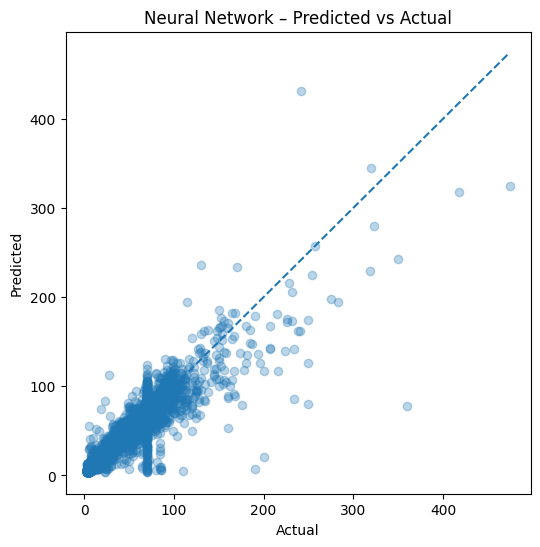

In [ ]:
%python
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(results["actual"], results["predicted"], alpha=0.3)
plt.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    linestyle="--"
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Neural Network – Predicted vs Actual")
plt.show()

In [ ]:
%python
df.createOrReplaceTempView("nyc_taxi_raw")



In [ ]:



%python
spark.sql("""
SELECT
  DATE(tpep_pickup_datetime) AS pickup_date,
  COUNT(*) AS trips
FROM nyc_taxi_raw
GROUP BY pickup_date
ORDER BY pickup_date
""").show()




+-----------+------+
|pickup_date| trips|
+-----------+------+
| 2001-01-01|     6|
| 2002-12-31|    11|
| 2003-01-01|     6|
| 2008-12-31|    23|
| 2009-01-01|    15|
| 2014-11-19|     1|
| 2022-10-24|     4|
| 2022-10-25|     7|
| 2022-12-31|    25|
| 2023-01-01| 76752|
| 2023-01-02| 65777|
| 2023-01-03| 85783|
| 2023-01-04| 95092|
| 2023-01-05|101063|
| 2023-01-06|102550|
| 2023-01-07|105036|
| 2023-01-08| 85056|
| 2023-01-09| 85349|
| 2023-01-10| 99916|
| 2023-01-11|106118|
+-----------+------+
only showing top 20 rows


In [ ]:
spark.sql("""
SELECT
  ROUND(AVG(trip_distance), 2) AS avg_distance_km,
  ROUND(AVG(fare_amount), 2) AS avg_total_fare
FROM nyc_taxi_raw
WHERE trip_distance > 0
""").show()


+---------------+--------------+
|avg_distance_km|avg_total_fare|
+---------------+--------------+
|           4.17|         19.44|
+---------------+--------------+



In [ ]:
spark.sql("""
SELECT
  HOUR(tpep_pickup_datetime) AS pickup_hour,
  COUNT(*) AS trips,
  ROUND(AVG(fare_amount), 2) AS avg_revenue
FROM nyc_taxi_raw
GROUP BY pickup_hour
ORDER BY avg_revenue DESC
""").show()


+-----------+-------+-----------+
|pickup_hour|  trips|avg_revenue|
+-----------+-------+-----------+
|          5| 226411|      27.45|
|          4| 217492|      23.55|
|          6| 532181|      22.96|
|         15|2371342|      20.96|
|         14|2311519|      20.92|
|         16|2374464|      20.91|
|         23|1581733|      20.72|
|         13|2157093|      20.23|
|          0|1088628|      19.86|
|         22|1994411|      19.64|
|         17|2581999|      19.57|
|          7|1044241|      19.47|
|         12|2090720|      19.32|
|         11|1925489|      18.98|
|         10|1773717|      18.84|
|         21|2151209|      18.83|
|         20|2153613|      18.68|
|          9|1632601|      18.62|
|          8|1446062|      18.61|
|         19|2416756|      18.19|
+-----------+-------+-----------+
only showing top 20 rows


In [ ]:
spark.sql("""
SELECT
  ROUND(
    AVG(
      (unix_timestamp(tpep_dropoff_datetime) -
       unix_timestamp(tpep_pickup_datetime)) / 60
    ), 2
  ) AS avg_trip_duration_min
FROM nyc_taxi_raw
WHERE tpep_dropoff_datetime > tpep_pickup_datetime
""").show()


+---------------------+
|avg_trip_duration_min|
+---------------------+
|                17.46|
+---------------------+



In [ ]:
spark.sql("""
SELECT
  PULocationID,
  COUNT(*) AS trips
FROM nyc_taxi_raw
GROUP BY PULocationID
ORDER BY trips DESC
LIMIT 10
""").show()


+------------+-------+
|PULocationID|  trips|
+------------+-------+
|         132|1992304|
|         237|1791795|
|         161|1766041|
|         236|1596584|
|         162|1353753|
|         138|1305259|
|         186|1305113|
|         230|1270681|
|         142|1256024|
|         170|1131673|
+------------+-------+



In [ ]:
spark.sql("""
SELECT
  CASE
    WHEN trip_distance < 2 THEN '0–2 km'
    WHEN trip_distance < 5 THEN '2–5 km'
    WHEN trip_distance < 10 THEN '5–10 km'
    ELSE '10+ km'
  END AS distance_bucket,
  COUNT(*) AS trips,
  ROUND(AVG(fare_amount), 2) AS avg_fare
FROM nyc_taxi_raw
WHERE trip_distance > 0
GROUP BY distance_bucket
ORDER BY distance_bucket DESC
""").show()


+---------------+--------+--------+
|distance_bucket|   trips|avg_fare|
+---------------+--------+--------+
|        5–10 km| 3322980|   33.96|
|         2–5 km|10543839|   18.84|
|         10+ km| 3332318|   63.98|
|         0–2 km|20337632|   10.07|
+---------------+--------+--------+

